In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - JAX DITO

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_jax_dito.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>

  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_jax_dito.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>                                                                                               <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_jax_dito.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
  </td>
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.10

## Overview

This notebook demonstrates serving a [JAX DITO model](https://github.com/google-research/google-research/tree/master/fvlm/dito) for [open-vocabulary object detection and instance segmentation](https://arxiv.org/abs/2310.00161) tasks and deploying them on Vertex AI for online prediction.

### Objective

In this tutorial, you learn how to:

- Upload the model to [Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model on [Endpoint](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for open-vocabulary image object detection and instance segmentation.

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Model Registry
- Vertex AI Online Prediction

### Dataset

This notebook uses the following prediction image as an example:

Image: https://pixabay.com/nl/photos/het-fruit-eten-citroen-limoen-3134631/

Creative Commons License: https://pixabay.com/nl/service/terms/

You can use your own custom prediction image as well as by modifying the `DEMO_IMAGE_PATH` variable in this notebook below.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [ ]:
# Install the packages.
! pip3 install --upgrade google-cloud-aiplatform
! sudo apt-get install -y subversion protobuf-compiler python3-lxml\
  python3-pip python3-dev git unzip
# Note: The following libraries are pinned down versions of:
# https://github.com/google-research/google-research/blob/master/fvlm/requirements.txt
! pip install tensorflow==2.14.0
! pip install tensorflow_text==2.14.0
! pip install tensorflow-datasets==4.9.2
! pip install numpy==1.23.5
! pip install torch==2.0.1+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
! pip install torchvision==0.15.2+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
! pip install opencv-python==4.7.0.72
! pip install git+https://github.com/openai/CLIP.git@a1d071733d7111c9c014f024669f959182114e33
! pip install Pillow==9.1.1
! pip install orbax-checkpoint==0.3.3
! pip install pycocotools==2.0.6
! pip install contextlib2==21.6.0
! pip install ml-collections==0.1.1
! pip install chex==0.1.7
! pip install optax==0.1.5
# Dependencies already included. Use no-deps to not update numpy.
! pip install --no-deps flax==0.7.2
! pip install --no-deps clu==0.0.9
! pip install jax[cuda11_cudnn86]==0.4.9 \
  --find-links https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# Get DITO repository together with fvlm repository by using svn to avoid downloading entire
# google-research repository.
%cd
! rm -rf ./fvlm
# Revision 60813 at 2023-11-14 17:37:47 +0000,
! svn export -r 606813 https://github.com/google-research/google-research/trunk/fvlm

In [ ]:
%cd ./fvlm/dito/checkpoints
! bash ./download.sh

%cd ../embeddings
! bash ./download.sh

%cd ../../

### Restart kernel

In [ ]:
# Restart kernel after installs so that your environment can access the new packages.
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).

1. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Check your accelerator [quota](https://console.cloud.google.com/iam-admin/quotas). This notebook uses TPU V3 8 cores, you can filter and request `Custom model training TPU V3 cores per region` quota for 8 cores for the `Vertex AI API` service in your region.


### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = ""  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [ ]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

### Import libraries

In [ ]:
import base64
import functools
import os
import sys
from io import BytesIO

import jax
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tqdm
from PIL import Image

os.chdir(os.path.expanduser("~"))  # cd to home directory.
sys.path.append(os.path.join(os.getcwd(), "fvlm"))
from demo_utils import input_utils as inputs
from demo_utils import vis_utils
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
from utils import clip_utils

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [ ]:
staging_bucket = os.path.join(BUCKET_URI, "jax_dito_staging")
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=staging_bucket)

### Define constants

In [ ]:
REGION_PREFIX = REGION.split("-")[0]

# Tokenizer path.
TOKENIZER_DIR = "./fvlm/dito/checkpoints/tokenizer/dito_tokenizer.model"
# Text encoder model path.
TEXT_MODEL_DIR = "./fvlm/dito/checkpoints/text_model/"
# Background and empty embedding path.
EMBED_PATH = "./fvlm/dito/embeddings/bg_empty_embed.npy"

# GCS location of the category embeddings file.
GCS_CATEGORY_EMBEDDING_PATH = f"{BUCKET_URI}/embeddings/dito/embed.npy"

# An upper bound on the number of classes.
MAX_NUM_CLS = 1204

# The pre-built prediction docker image.
OPTIMIZED_TF_RUNTIME_IMAGE_URI = f"{REGION_PREFIX}-docker.pkg.dev/vertex-ai-restricted/prediction/tf_opt-cpu.nightly:latest"

# The max number of boxes to draw on the output image.
MAX_BOXES_TO_DRAW = 25
# The minimum score required to draw a detected object.
MIN_SCORE_THRESH = 0.2  # @param {type:"slider", min:0, max:0.9, step:0.05}
# The local path to the output image.
OUTPUT_IMAGE_PATH = "./output.jpg"

# The DITO SavedModel folder which takes image and text embeddings as inputs.
LOCAL_SAVED_MODEL_DIR = "./fvlm/dito/checkpoints/vit-large"
# The converted SavedModel folder which takes jpeg bytes as input.
LOCAL_CONVERTED_SAVED_MODEL_DIR = "./converted_saved_model"
# The Cloud Storage location for the converted SavedModel.
GCS_CONVERTED_SAVED_MODEL_DIR = f"{BUCKET_URI}/dito_saved_model"

### Define common functions

This section defines functions for:

- Loading and converting input image into the required prediction format.
- Visualization of detection outputs.
- Generating text embeddings.


In [ ]:
def get_jpeg_bytes(local_image_path, new_width=-1):
    """Returns jpeg bytes given an image path and resizes if required."""
    image = Image.open(local_image_path)
    if new_width <= 0:
        new_image = image
    else:
        width, height = image.size
        print("original input image size: ", width, " , ", height)
        new_height = int(height * new_width / width)
        print("new input image size: ", new_width, " , ", new_height)
        new_image = image.resize((new_width, new_height))
    buffered = BytesIO()
    new_image.save(buffered, format="JPEG")
    return buffered.getvalue()


def generate_prediction_output_image(
    input_image_path, prediction_output, output_image_path, categories
):
    """Generates prediction output image with detected objects and bounding boxes."""
    # Generate tensors from prediction outputs.
    prediction_output_tensor = {}
    for key, val in prediction_output.items():
        prediction_output_tensor[key] = tf.expand_dims(
            tf.convert_to_tensor(val), axis=0
        )
    prediction_output_tensor["num_detections"] = tf.cast(
        prediction_output_tensor["num_detections"], tf.int32
    )
    # Generate image embeddings for the input image.
    with open(input_image_path, "rb") as f:
        np_image = np.array(Image.open(f))
    parser_fn = inputs.get_maskrcnn_parser()
    data = parser_fn({"image": np_image, "source_id": np.array([0])})
    np_data = jax.tree_map(lambda x: x.numpy()[np.newaxis, Ellipsis], data)
    image_embeddings = np_data.pop("images")
    labels = np_data.pop("labels")
    # Generate visualization.
    print("Preparing visualization.")
    id_mapping = {i: c for i, c in enumerate(categories)}
    for k in range(len(categories) + 1, MAX_NUM_CLS):
        id_mapping[k] = "empty"
    category_index = inputs.get_category_index(id_mapping)
    maskrcnn_visualizer_fn = functools.partial(
        vis_utils.visualize_boxes_and_labels_on_image_array,
        category_index=category_index,
        use_normalized_coordinates=False,
        max_boxes_to_draw=MAX_BOXES_TO_DRAW,
        min_score_thresh=MIN_SCORE_THRESH,
        skip_labels=False,
    )
    vis_image = vis_utils.visualize_instance_segmentations(
        prediction_output_tensor,
        image_embeddings,
        labels["image_info"],
        maskrcnn_visualizer_fn,
    )
    pil_vis_image = Image.fromarray(vis_image, mode="RGB")
    pil_vis_image.save(output_image_path)
    print("Completed saving the output image at: ", output_image_path)


def generate_text_embeddings(categories):
    """Generates text embeddings in numpy format from object categories."""

    class_clip_features = []
    tokenizer = clip_utils.get_tokenizer(TOKENIZER_DIR)
    text_model = tf.saved_model.load(TEXT_MODEL_DIR)
    for cls_name in tqdm.tqdm(categories, total=len(categories)):
        cls_feat = clip_utils.tokenize_pad_fn(tokenizer, text_model, cls_name)
        class_clip_features.append(cls_feat)

    text_embeddings = np.concatenate(class_clip_features, axis=0)
    background_embedding, empty_embeddings = np.load(EMBED_PATH)
    background_embedding = background_embedding[np.newaxis, Ellipsis]
    empty_embeddings = empty_embeddings[np.newaxis, Ellipsis]
    tile_empty_embeddings = np.tile(
        empty_embeddings, (MAX_NUM_CLS - len(categories) - 1, 1)
    )
    # Concatenate 'background' and 'empty' embeddings.
    text_embeddings = np.concatenate(
        (background_embedding, text_embeddings, tile_empty_embeddings), axis=0
    )
    text_embeddings = text_embeddings[np.newaxis, Ellipsis]
    return text_embeddings

Create category embeddings. You can modify `CATEGORIES` for any custom categories.

In [ ]:
CATEGORIES = [
    "kiwi",
    "orange",
    "lemon",
    "blackberry",
    "pine cone",
    "red orange",
    "table",
    "spoon",
    "pine needles",
    "seed",
]
text_embeddings = generate_text_embeddings(categories=CATEGORIES)
with tf.io.gfile.GFile(GCS_CATEGORY_EMBEDDING_PATH, "w") as f:
    np.save(f, text_embeddings)

## Convert DITO SavedModel to support smaller input size

The DITO SavedModel takes image and text embeddings as input. But you can not send these inputs directly for Vertex AI Online Prediction because there is a limit of 1.5 MB on the prediction request size. So you will first convert the SavedModel format to take jpeg bytes as an input instead. This modified input format will meet the 1.5 MB limit requirement.

In [ ]:
def preprocess_jpeg_byte_string(tensor_byte_string):
    """Converts jpeg bytes to image embeddings as an input for the original DITO SavedModel."""
    decoded_image_tensor = tf.io.decode_jpeg(tensor_byte_string, channels=3)
    parser_fn = inputs.get_rovit_parser()
    parser_output = parser_fn(
        {"image": decoded_image_tensor, "source_id": np.array([0])}
    )
    return parser_output["images"]


def get_serve_fn(model):
    """Creates a serving function for the modified SavedModel which takes jpeg bytes and text-embeddings bytes as an input."""

    # Load text embeddings.
    with tf.io.gfile.GFile(GCS_CATEGORY_EMBEDDING_PATH, "rb") as f:
        text_embeddings = np.load(f)

    @tf.function(
        input_signature=[
            tf.TensorSpec([None], tf.string),
        ]
    )
    def serve_fn(image_jpeg_bytes_inputs):
        image_embeddings_tensor = tf.map_fn(
            preprocess_jpeg_byte_string, image_jpeg_bytes_inputs, dtype=tf.bfloat16
        )
        return model({"image": image_embeddings_tensor, "text": text_embeddings})

    return serve_fn


! rm -rf {LOCAL_CONVERTED_SAVED_MODEL_DIR}
model = tf.saved_model.load(LOCAL_SAVED_MODEL_DIR)
signatures = {
    "serving_default": get_serve_fn(model=model).get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string)
    )
}
tf.saved_model.save(model, LOCAL_CONVERTED_SAVED_MODEL_DIR, signatures=signatures)
print("Saved the converted SavedModel to directory: ", LOCAL_CONVERTED_SAVED_MODEL_DIR)

Copy the local converted TF SavedModel to Cloud Storage.

In [ ]:
! gsutil -m rm -R -f {GCS_CONVERTED_SAVED_MODEL_DIR}
! gsutil -m cp -R {LOCAL_CONVERTED_SAVED_MODEL_DIR} {GCS_CONVERTED_SAVED_MODEL_DIR}
! gsutil ls {GCS_CONVERTED_SAVED_MODEL_DIR}

## Run online prediction
Run online prediction with the converted TF SavedModel.

Upload TF SavedModel and deploy it to an endpoint for prediction. This step can take up to 15 minutes to finish.

In [ ]:
serving_env = {
    "MODEL_ID": "jax-dito",
}

jax_dito_model = aiplatform.Model.upload(
    display_name="jax_dito",
    artifact_uri=GCS_CONVERTED_SAVED_MODEL_DIR,
    serving_container_image_uri=OPTIMIZED_TF_RUNTIME_IMAGE_URI,
    serving_container_args=[],
    location=REGION,
    serving_container_environment_variables=serving_env,
)

jax_dito_endpoint = jax_dito_model.deploy(
    deployed_model_display_name="jax_dito_deployed",
    traffic_split={"0": 100},
    machine_type="n1-highmem-16",
    min_replica_count=1,
    max_replica_count=1,
)

Prepare input prediction image.

Note: You can modify the input image as required.

In [ ]:
# Local path to the prediction image.
DEMO_IMAGE_PATH = "./prediction_image.jpg"
# Download the prediction image.
! wget -O {DEMO_IMAGE_PATH} https://cdn.pixabay.com/photo/2018/02/06/12/37/fruit-3134631_1280.jpg

Prepare jpeg bytes inputs.

In [ ]:
image_jpeg_bytes_inputs = get_jpeg_bytes(
    local_image_path=DEMO_IMAGE_PATH, new_width=1024
)

Use base-64 encoding followed by UTF-8 decoding to package the bytes inputs and then send them to the endpoint for prediction. The Vertex AI Prediction service will automatically convert these input strings back to bytes based on the `b64` keyword.

**Note: The first prediction can take up to 2 minutes due to one time initialization of the model. This may cause a timeout error below. If you get a timeout error, then wait for 2 minutes and run the prediction again. You will not get the timeout error after that.**
The subsequent predictions take 50 seconds to finish.

In [ ]:
instances_list = [
    {
        "image_jpeg_bytes_inputs": {
            "b64": base64.b64encode(image_jpeg_bytes_inputs).decode("utf-8")
        },
    }
]
instances = [json_format.ParseDict(s, Value()) for s in instances_list]
prediction_output = jax_dito_endpoint.predict(instances=instances).predictions[0]

Generate output image with predicted bounding boxes, labels, and probabilities. The output image will be saved to `OUTPUT_IMAGE_PATH`.

Preparing visualization.
Completed saving the output image at:  ./output.jpg


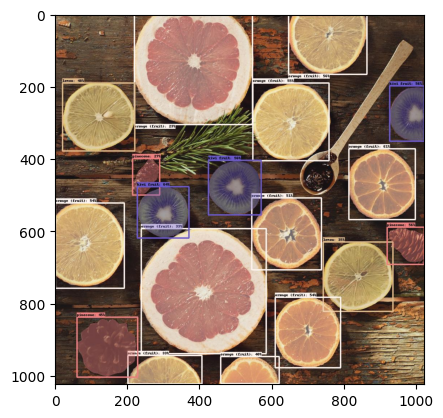

In [30]:
generate_prediction_output_image(
    input_image_path=DEMO_IMAGE_PATH,
    prediction_output=prediction_output,
    output_image_path=OUTPUT_IMAGE_PATH,
    categories=CATEGORIES,
)

img = Image.open(OUTPUT_IMAGE_PATH)
plt.imshow(img)

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
# Delete endpoint resource.
jax_dito_endpoint.delete(force=True)

# Delete model resource.
jax_dito_model.delete()

# Delete Cloud Storage objects that were created.
delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI